## Setting Environment

In [1]:
#!/usr/bin/env python3
%matplotlib inline

In [2]:
import os
os.getenv("PYTHONPATH")

'/opt/ros/melodic/lib/python2.7/dist-packages'

## Start

In [3]:
from collections import namedtuple

import matplotlib
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

In [4]:
import rospy
from sensor_msgs.msg import Image
from std_srvs.srv import Empty

import sys
sys.path = ["/home/pat/catkin_workspace/install/lib/python3/dist-packages"] + sys.path

from cv_bridge import CvBridge

import numpy as np

In [5]:
# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [6]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [7]:
class DQN(nn.Module):

    def __init__(self, h, w, outputs):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(32)

        # Number of Linear input connections depends on output of conv2d layers
        # and therefore the input image size, so compute it.
        def conv2d_size_out(size, kernel_size = 5, stride = 2):
            return (size - (kernel_size - 1) - 1) // stride  + 1
        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w)))
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h)))
        linear_input_size = convw * convh * 32
        self.head = nn.Linear(linear_input_size, outputs)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        return self.head(x.view(x.size(0), -1))

In [8]:
BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 10

resize = T.Compose([T.ToPILImage(),
                    T.Resize(100),
                    T.ToTensor()])

In [9]:
class QuadRotor(object):
    def __init__(self):
        
        rospy.init_node("quad",anonymous=True)
        
        self.br = CvBridge()
        self.rate = rospy.Rate(10)
        
        rospy.Subscriber("/camera1/image_raw",Image,self.image_converter)
        
        print("Waiting for service.......")
        
        rospy.wait_for_service('/gazebo/reset_world')
        
        self.reset_world = rospy.ServiceProxy("/gazebo/reset_world",Empty)
        
        print("Initialize success!!!")
        
    def image_converter(self,msg):
        tmp_image = self.br.imgmsg_to_cv2(msg).transpose((2,0,1))
        tmp_image = np.ascontiguousarray(tmp_image, dtype=np.float32) / 255
        tmp_image = torch.from_numpy(tmp_image)
        self.image = resize(tmp_image).unsqueeze(0).to(device)
#         print("OK!")
    
    def show_image(self):
        plt.imshow(self.image.cpu().squeeze(0).permute(1, 2, 0).numpy(),interpolation='none')
    
    def reset(self):
        self.reset_world()    

In [10]:
Quad = QuadRotor()

Waiting for service.......
Initialize success!!!


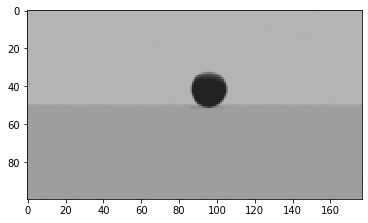

In [12]:
Quad.show_image()

In [13]:
_,_,screen_hight,screen_width = Quad.image.shape
n_action = 8
screen_width

177